<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 16 (delta 8), pack-reused 569 (from 1)
Receiving objects: 100% (653/653), 62.41 MiB | 9.16 MiB/s, done.
Resolving deltas: 100% (335/335), done.
Updating files: 100% (118/118), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.42.4
Using datasets v2.21.0
Using accelerate v0.32.1
Using sentencepiece v0.1.99
Using umap v0.5.6
No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.


# 텍스트 분류

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_tweet.png?raw=1" id="tesla-tweet"/>

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_hf-libraries.png?raw=1" id="hf-libraries"/>

## 데이터셋

### 허깅 페이스 데이터셋 처음 사용하기

In [2]:
from huggingface_hub import list_datasets

all_datasets = [ds.id for ds in list_datasets()]
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


현재 허브에는 204592개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['amirveyseh/acronym_identification',
'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa',
'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news',
'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar',
'legacy-datasets/allegro_reviews']


각 데이터셋은 고유한 이름이 있습니다. `load_dataset()` 함수로 `emotion` 데이터셋을 로드해보죠.

In [3]:
from datasets import load_dataset

# emotion 데이터셋이 다운로드되지 않으면 SetFit/emotion을 사용합니다.
emotions = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
# SetFit/emotion 데이터셋의 경우 수동으로 ClassLabel 객체를 만들어 label에 할당합니다.
from datasets import ClassLabel

emotions['train'].features['label'] = ClassLabel(
    num_classes=6,
    names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"] # emotions라는 데이터셋 객체에서 훈련 데이터 부분을 가져오겠다는 의미
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [11]:
len(train_ds)

16000

In [12]:
train_ds[0] # 훈련 데이터 부분의 첫 번째 항목

{'text': 'i didnt feel humiliated', 'label': 0}

In [13]:
train_ds.column_names # 열 이름(column names)들을 반환하는 속성

['text', 'label']

In [14]:
print(train_ds.features) # 데이터셋의 특징(feature) 정보

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [15]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


- 굴욕감이 없다는 긍정적인 표현이지만, 문맥상 '슬픔'의 요소를 내포하고 있을 수 있음 → 0 (슬픔)
- 나는 너무 절망적인 기분에서 너무 지옥 같은 기분까지 갈 수 있다… → 0 (슬픔)
- 잠깐 시간을 내어 게시하는데, 나는 탐욕스럽고 잘못된 기분이 든다 → 3 (분노)
- 나는 항상 벽난로에 대해 향수를 느낀다 → 2 (사랑)
- 나는 까칠한 기분이 든다 → 3 (분노)

In [16]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


### 사이드바: 허브에 필요한 데이터셋이 없다면 어떻게 하나요?

In [17]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2024-09-03 00:57:27--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 18.154.227.87, 18.154.227.7, 18.154.227.67, ...
Connecting to huggingface.co (huggingface.co)|18.154.227.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  --.-KB/s    in 0.1s    

2024-09-03 00:57:27 (16.4 MB/s) - ‘train.txt’ saved [1658616/1658616]



In [18]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [19]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
                              names=["text", "label"])

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                               names=["text", "label"])

Generating train split: 0 examples [00:00, ? examples/s]

### 사이드바 끝

### 데이터셋에서 데이터프레임으로

In [21]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

- emotions처럼 객체의 형태로 저장되어 있을 때 set_format을 사용하여 데이터셋에서 데이터프레임으로 바꿈

In [22]:
import pandas as pd # pandas를 불러와

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head() # 딕셔너리 형테 -> 표 형태

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [23]:
emotions["train"].features['label'].__class__
# 'label' 열이 어떤 클래스 타입으로 정의되어 있는지 확인하는 코드
# ClassLabel 형태로 정의되었는지 알 수 있음

datasets.features.features.ClassLabel

In [24]:
# 숫자 형식의 레이블을 해당하는 문자열 형식의 레이블로 변환한 후, 이를 데이터프레임에 추가하는 작업
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 클래스 분포 살펴 보기
- 텍스트 분류 문제를 다룰 때는 언제나 샘플의 클래스 분포를 조사하는 것이 좋음
    - 맷플로립 사용하면 빠르게 클래스 분포를 시각화 할 수 있음

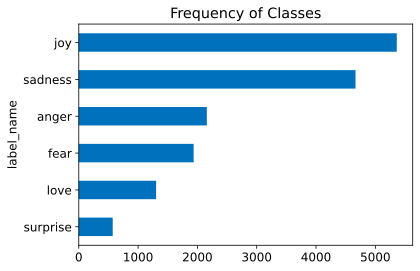

In [25]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

- joy와 sadness 클래스가 많이 등장하고, love와 surprise 클래스는 5~10배나 더 적은 것을 알 수 있음
    - 불균형한 데이터 처리 방법
        - 소수 클래스를 랜덤하게 오버샘플링
        - 다수 클래스를 랜덤하게 언더샘플링
        - 클래스의 대표성이 부족하다면 레이블된 데이터를 더 많이 수집함

- 그러나 본 교재에서 문제를 간단하게 하기 위해 불균형 클래스를 그대로 사용하겠음

### 트윗 길이 확인

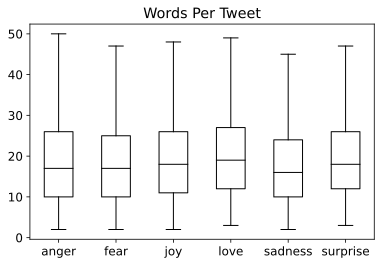

In [26]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

- 각 감정의 트윗의 길이는 15개 정도임을 알 수 있음

- 더 이상 DataFrame 포맷이 필요하지 않으니 데이터셋의 출력 포맷을 초기화

In [27]:
emotions.reset_format()

## 텍스트에서 토큰으로

### 문자 토큰

In [28]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


In [29]:
# 각 토큰을 고유한 정수로 인코딩함
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


In [30]:
# token2idx를 활용해 tokenized_text(토큰화된 텍스트)를 정수 리스트로 변환
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


- 문자 토큰화의 마지막 단계는 input_ids를 원-핫 벡터의 2D 텐서로 바꾸는 것
    - ex) input_ids = 5이라면,
        - [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    - 이것을 2D 텐서로 바꾸겠다는 것은???
        - [ [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], …]

- 방법 1. pd.get_dummies() 사용하여  원핫인코딩하기

In [31]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [32]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


- 방법 2. 파이토치로 input_ids를 텐서로 바꾸고, one_hot()함수 사용해 원핫인코딩하기

In [33]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [34]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [35]:
print(F.one_hot(torch.tensor([0,2]), num_classes=11))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


In [36]:
F.one_hot(torch.tensor([0,2]), num_classes=11).shape

torch.Size([2, 11])

- 방법 3. tensorflow로 원핫벡터 만들기

In [37]:
import tensorflow as tf

tf.one_hot([0, 1, 2], 3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

### 단어 토큰화

In [38]:
# 띄어쓰기
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### 부분단어 토큰화

- **트랜스포머**는 사전 훈련된 모델에 연관된 토크나이저를 빠르게 로드하는 `AutoTokenizer 클래스`를 제공함.
- `from_pretrained() 메서드`를 허브 모델 ID나 로컬 파일 경로와 함께 호출하면 됨

In [39]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

- 단어가 inputs_ids 필드에 있는 고유한 정수로 매핑됨

In [40]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


- covert_ids_to_tokens() 메서드를 사용해 이를 다시 토큰으로 변환함

In [41]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


In [42]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [43]:
tokenizer.vocab_size # 토크나이저가 가진 어휘(vocabulary)의 크기, 즉 토큰의 총 개수

30522

In [44]:
tokenizer.model_max_length # 모델이 처리할 수 있는 입력 시퀀스의 최대 길이

512

### 전체 데이터셋 토큰화하기

In [45]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [46]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


- input_ids의 첫번째 원소가 두번째보다 더 짧으므로 길이를 동일하게 맞추기 위해 끝에 0을 추가했음

- all_special_token과 all_special_ids를통해 특수문자 토큰 & id 결과 확인
    - [PAD; Padding]: 빈칸 채우기
    - [UNK; Unknown]: 모르는 단어
    - [CLS; Classification]: 모든 sequence의 시작
    - [SEP; Separator]: 2개의 sequence를 구분
    - [MASK]: 단어를 숨기고 나중에 맞추도록 하는 역할

In [47]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


- tokenize 함수 결과에서도 알 수 있듯,
토크나이저는
1) 인코딩된 트윗을 input_ids로 반환하고
2) attention_mask 배열 리스트도 반환

- 코드 한 줄로 아래 그림과 같은 과정이 진행됨
    - 배치마다 입력 시퀀스는 배치에서 가장 긴 시퀀스 길이에 맞춰 패딩됨
    - 어텐션 마스크는 모델이 입력 텐서에서 패딩 영역을 무시하는데 사용됨

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/>

- 모든 샘플에 개별적으로 적용하기 위해 map() 사용
    - batched=True : 트윗을 배치로 인코딩
    - batch_size=None : 전체 데이터셋이 하나의 배치로 tokenize()에 적용

In [48]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [49]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## 텍스트 분류 모델 훈련하기

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

- (1) 토큰 인코딩
    - 텍스트를 토큰화해 토큰 인코딩이라 부르는 웟-핫 벡터로 나타냄
- (2) 토큰 임베딩
    - 토큰 인코딩을 저차원 공간인 벡터인 토큰 임베으로 변환함
- (3) 인코더 블록 층에 통과 시켜 각 입력 토큰에 대한 은닉 상태를 만듦.
- (4) 각 은닉 상태는 언어 모델링의 사전 훈련 목표를 달성하기 위해 예측 층으로 전달 됨

- 모델을 훈련하는 방법에는
    - 특성 추출: 사전 훈련된 모델을 수정 X, 은닉 상태를 특성으로 사용해 분류 모델을 훈련
    - 미세튜닝: 사전 훈련된 모델의 파라미터 업데이트를 위해 전체 모델을 엔드 투 엔드로 훈련

### 트랜스포머를 특성 추출기로 사용하기

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### 사전 훈련된 모델 사용하기

In [50]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### 사이드바: 프레임워크 간의 상호 운영성

In [ ]:
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [ ]:
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

### 사이드바 끝

#### 마지막 은닉 상태 추출하기

In [51]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


In [52]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad(): # 훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 자체 특성으로 사용함
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]),
hidden_states=None, attentions=None)


In [53]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [54]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [55]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [58]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [59]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [60]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### 특성 행렬 만들기

In [61]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### 훈련 세트 시각화하기

- 768차원의 은닉 상탤르 시각화하기는 어렵기에 umap 알고리즘을 사용해서 2D로 투영

In [62]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.954024,6.481934,0
1,-3.458855,5.624678,0
2,5.371664,3.071936,3
3,-2.555124,3.595919,2
4,-3.615521,3.660992,3


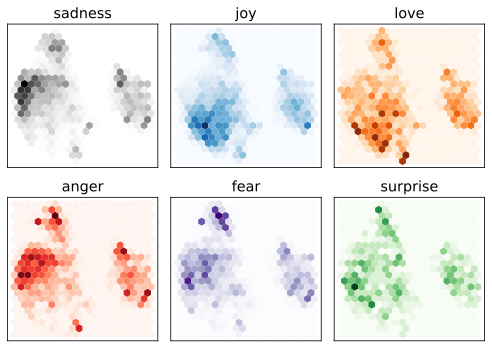

In [63]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

- sadness, anger, fear 같은 부정적인 감정은 조금씩 다르게 분포되어 있음
- 반면 joy, love는 부정적인 감정과 잘 분리되고 비슷한 영역을 차지함을 알 수 있음.
- surprise는 영역 전체에 골고루 퍼져 있음

#### 간단한 분류 모델 훈련하기

- 로지스틱 회귀

In [64]:
# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
# LogisticRegression 모델을 생성max_iter=3000으로 설정
# 이는 모델이 훈련될 때 최대 3000번의 반복을 통해 가중치를 조정한다는 의미
lr_clf.fit(X_train, y_train) # 입력 데이터와 레이블 간의 관계를 학습

LogisticRegression(max_iter=3000)

In [65]:
lr_clf.score(X_valid, y_valid) # 모델이 검증 데이터에서 올바르게 예측한 비율

0.6335

- 근데 우리의 데이터셋은 불균형함
- 그러므로 가장 빈번하게 등장하는 클래스를 항상 예측하는 모델 정확도를 살펴보자.

- 사이킷런의 DummyClassifier

In [66]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
# 가장 빈번하게 등장하는 클래스를 항상 예측하는 모델
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

- 이를 통해 Logistic Regression 모델의 정확도가 Dummy Classifier보다 훨씬 높으므로, 이 모델이 데이터를 더 효과적으로 분석하고 예측할 수 있음을 보여줍니다.

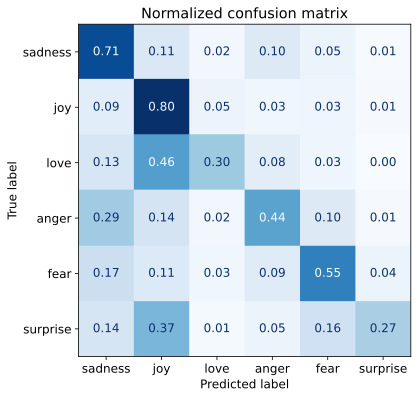

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 트랜스포머 미세 튜닝하기

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

#### 사전 훈련된 모델 로드하기

In [68]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

#### 성공 지표 정의하기

In [69]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기

In [70]:
from huggingface_hub import notebook_login

notebook_login()

In [71]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [72]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.818400,0.314683,0.908500,0.907596


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.818400,0.314683,0.908500,0.907596
2,0.250000,0.216775,0.925500,0.925545


In [73]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [74]:
preds_output.metrics

{'test_loss': 0.21677544713020325,
 'test_accuracy': 0.9255,
 'test_f1': 0.9255447286805336,
 'test_runtime': 227.4124,
 'test_samples_per_second': 8.795,
 'test_steps_per_second': 0.141}

In [75]:
y_preds = np.argmax(preds_output.predictions, axis=1)

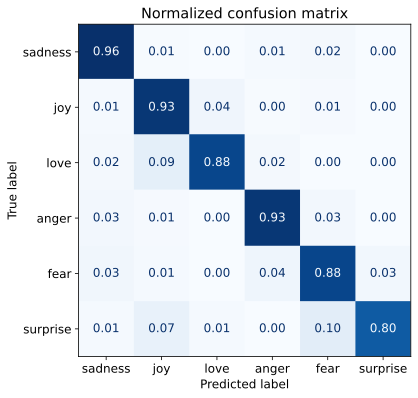

In [76]:
plot_confusion_matrix(y_preds, y_valid, labels)

### 사이드바: 케라스로 미세 튜닝하기

In [ ]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
# 텐서플로 텐서로 변환할 열 이름
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols="label", shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols="label", shuffle=False,
    batch_size=batch_size)

In [ ]:
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 161s 534ms/step - loss: 0.5283 - sparse_categorical_accuracy: 0.8155 - val_loss: 0.1831 - val_sparse_categorical_accuracy: 0.9285
Epoch 2/2
250/250 [==============================] - 129s 517ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.9381 - val_loss: 0.1456 - val_sparse_categorical_accuracy: 0.9400


### 사이드바 끝

#### 오류 분석

In [77]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [78]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [79]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [80]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.607235
1950,i as representative of everything thats wrong ...,surprise,sadness,5.411012
1801,i feel that he was being overshadowed by the s...,love,sadness,5.335728
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.282458
1111,im lazy my characters fall into categories of ...,joy,fear,5.257744
1274,i am going to several holiday parties and i ca...,joy,sadness,5.216582
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.035945
1509,i guess this is a memoir so it feels like that...,joy,fear,4.812418
765,i feel super awkward and out of place right now,joy,sadness,4.663469
882,i feel badly about reneging on my commitment t...,love,sadness,4.648878


In [81]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
632,i feel he is an terrific really worth bet,joy,joy,0.014886
1619,i sat in the car and read my book which suited...,joy,joy,0.015162
1090,i dont know what it is about me and sweets the...,joy,joy,0.015256
131,i feel like a graph doesnt show the data accur...,joy,joy,0.015285
723,i was able to go to a st party i am back feeli...,joy,joy,0.015325
876,i feel like the cool mom,joy,joy,0.015342
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.015379
845,i already feel very glamorous have a great day...,joy,joy,0.015382
1622,i feel that it was a good investment to make t...,joy,joy,0.015434
1780,ive explained that he is very creative and lov...,joy,joy,0.015550


#### 모델 저장 및 공유

In [82]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/ssungni/distilbert-base-uncased-finetuned-emotion/commit/1184610f6c56907fcc4855fe0e2cf3890a208119', commit_message='Training completed!', commit_description='', oid='1184610f6c56907fcc4855fe0e2cf3890a208119', pr_url=None, pr_revision=None, pr_num=None)

In [83]:
from transformers import pipeline

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_id = "ssungni/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, top_k=None)

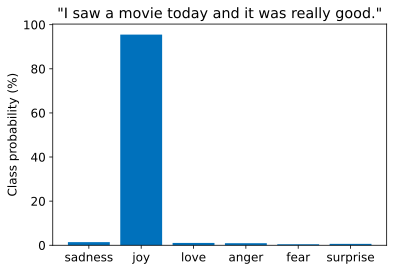

In [85]:
preds_sorted = sorted(preds, key=lambda d: d['label'])
preds_df = pd.DataFrame(preds_sorted)
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()